## Worksheet 6

### Group 22 Eaton Heidegger and Shannon Schröder

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

### One dimensional diffusion equation

We are solving the one dimensional diffusion equation, with the diffusion coefficient $D=1$ and considering the initial-boundary value problem:

$\frac{\partial\rho}{\partial t} = \frac{\partial^2\rho}{\partial^2 t}, \ \ \ \ \ x\in \big(-\frac{1}{2},\frac{1}{2}\big), \ \ \ \ \ t\geq 0 $

The initial condition is a piecewise function shaped like a small bump in the middle, with a periocic boundary condition:

$\rho(-\frac{1}{2}, t) = \rho(\frac{1}{2}, t)$

#### a) Stable FTCS Method

Here we use a FCTS to compute the solution for the IBVP with a final up to $T=5\cdot 10^{-3}$. We use $N=1000$ grid point and a time step of $\Delta t = 0.25(\Delta x)^2$, as it is given in the worksheet.

In [2]:
def initialize_grid(N, x_start=-0.5, x_end=0.5):
    dx = (x_end - x_start) / N
    x = np.linspace(x_start, x_end, N, endpoint=False)
    return x, dx

Here we set up a spatial grid $[-0.5, 0.5)$ and divide the interval into $N$ cells. The function returns $x$ grid and $dx$, the spatial step.

In [3]:
def initial_condition(x):
    rho = np.zeros_like(x)
    rho[np.abs(x) < 0.05] = 0.25
    rho[(np.abs(x) >= 0.05) & (np.abs(x) < 0.1)] = 0.5
    rho[(np.abs(x) >= 0.1) & (np.abs(x) < 0.15)] = 1.0
    return rho

Here we define the piecewise intial condition that were giving from the worksheet. It has a flat bump in the middle with $3$ values $(0.25, 0.5, 1.0). We also defined symmetrical step-like structure centered at $x=0$.

In [4]:
def ftcs_step(rho, alpha):
    rho_new = rho.copy()
    rho_new[1:-1] = rho[1:-1] + alpha * (rho[2:] - 2 * rho[1:-1] + rho[:-2])
    rho_new[0] = rho[0] + alpha * (rho[1] - 2 * rho[0] + rho[0])
    rho_new[-1] = rho[-1] + alpha * (rho[0] - 2 * rho[-1] + rho[-2])
    return rho_new

Here we implement the FCTS sheme for the diffusion, which is defined as

$\rho_i^{n+1} = \rho_i^n + \alpha \big[\rho_{i+1}^n - 2\rho_i^n + \rho_{i-1}^n]$ with $\alpha = \frac{\Delta t}{\Delta x^2}$

We also enforce the periodic boundary conditions, as the endpoints use neighbors from opposite sides (wrap around).

In [76]:
def solve_diffusion_ftcs(N=1000, T=5e-3):
    x, dx = initialize_grid(N)
    dt = 0.25 * dx**2
    alpha = dt / dx**2
    nt = int(T / dt)

    rho = initial_condition(x)
    save_times = [0, int(0.02 * nt), int(0.5 * nt), nt]
    snapshots = {0: rho.copy()}

    for n in range(1, nt + 1):
        rho = ftcs_step(rho, alpha)
        if n in save_times:
            snapshots[n] = rho.copy()

    return x, snapshots, T, save_times, nt

Here we compute the stable solution using:

$\Delta t = 0.25 \cdot \Delta x^2 \Rightarrow \alpha = 0.25$

More?

In [17]:
def plot_snapshots(x, snapshots, save_times, T, unstable=False):
    plt.figure(figsize=(10, 6))
    labels = ['t = 0', f't = {0.2*T:.1e}', f't = {0.5*T:.1e}', f't = {T:.1e}']
    for i, n in enumerate(save_times):
        plt.plot(x, snapshots[n], label=labels[i])
    title = 'FTCS Scheme with UNSTABLE Time Step (α > 0.5)' if unstable else 'Diffusion Equation Solved Using FTCS Scheme'
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('ρ(x, t)')
    plt.legend()
    plt.grid(True)
    plt.show()

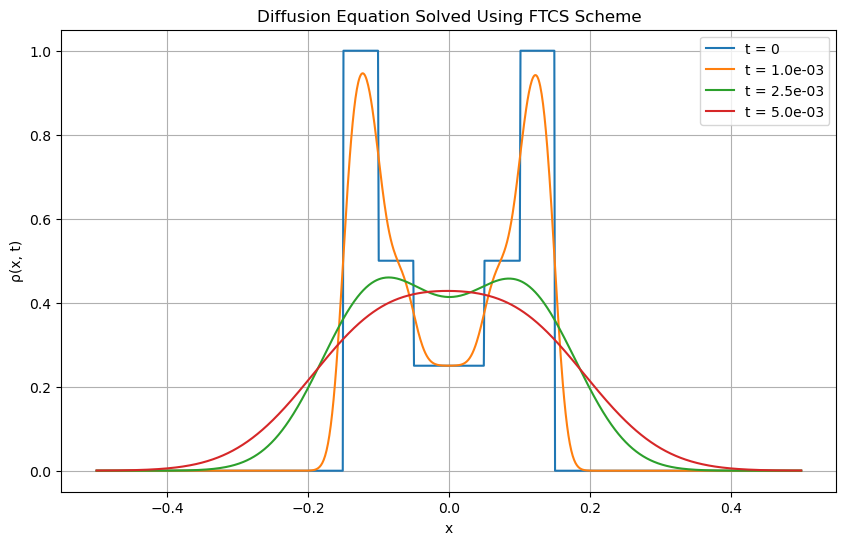

In [18]:
x, snapshots, T, save_times, nt = solve_diffusion_ftcs()
plot_snapshots(x, snapshots, save_times, T)

In the plot we can see for the initial condition, $t=0$, the curve is boxy and piecewise. As the time progresses, the sharp features diffuse smoothly, with a more rounded, symmetrical profile as more time passes.

#### b) Unstable FTCS Scheme

Now we test what happens when we break the stability condition of the FTCS method.

In [12]:
def solve_diffusion_ftcs_unstable(N=1000, T=5e-3, epsilon=1e-4):
    x, dx = initialize_grid(N)
    dt = (0.5 + epsilon) * dx**2  # unstable
    alpha = dt / dx**2
    nt = int(T / dt)

    rho = initial_condition(x)
    save_times = [0, int(0.1 * nt), int(0.3 * nt), nt]
    snapshots = {0: rho.copy()}

    for n in range(1, nt + 1):
        rho = ftcs_step(rho, alpha)
        if n in save_times:
            snapshots[n] = rho.copy()
    
    return x, snapshots, T, save_times

We slightly increase the time step, which result into $\alpha = 0.5001 > 0.5$. By violating the condition, the scheme becomes theoretically unstable.

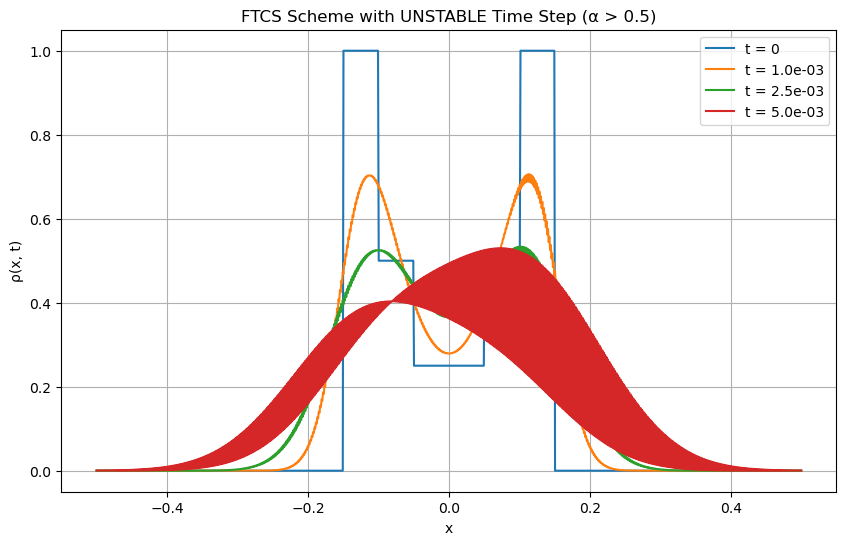

In [19]:
x, snapshots, T, save_times = solve_diffusion_ftcs_unstable()
plot_snapshots(x, snapshots, save_times, T, unstable=True)

This plot lookes similiar to the stable version in the earlier stages. With increasing time the curve shows slight wiggles, asymmetry and a slight thickening begins to show. In the final stage these effects are now more extreme. The curve is still smooth, but no longer physically accurate. 

#### c) Fourier Transform Solution

Now we are implementing the analytical (exact) solution using the Fourier transform, compare it to our FTCS solution and compute the error between them. For the one dimensional diffusion equation:

$\frac{\partial\rho}{\partial t} = \frac{\partial^2\rho}{\partial^2 t}$

with the periodic boundary conditions, we can expand the initial condition into a Fourier series:

$\rho (x,t) \sum_k \widehat{\rho_k}(0)e^{-k^2t}e^{ikx}$

To implemnt this we will use an FFT.

In [23]:
def fourier_solution(rho0, dx, t):
    N = len(rho0)
    k = 2 * np.pi * np.fft.fftfreq(N, dx)
    rho_hat = np.fft.fft(rho0)
    rho_hat_t = rho_hat * np.exp(-k**2 * t)
    rho_exact = np.fft.ifft(rho_hat_t).real
    return rho_exact

Here we compute the exact solution using an FFT. First we compute the wave number for the periodic domain. Then we compute the initial condition in Fourier space. Finally we convert the spectrum back to the physical space.

In [24]:
def compute_error(numerical, analytical):
    return np.linalg.norm(numerical - analytical) / np.linalg.norm(analytical, ord=2)

Here we compute the error using the normalized L2 norm (Euclidean norm) of the difference. This is a good measure for how far off the numerical solution is from the exact one.

In [25]:
def compare_solutions(N=1000, T=5e-3):
    x, dx = initialize_grid(N)
    dt = 0.25 * dx**2
    alpha = dt / dx**2
    nt = int(T / dt)

    rho0 = initial_condition(x)
    rho = rho0.copy()

    for _ in range(nt):
        rho = ftcs_step(rho, alpha)
    
    rho_exact = fourier_solution(rho0, dx, T)
    error = compute_error(rho, rho_exact)
    print(f"Relative L2 error at t = {T:.1e}: {error:.3e}")

    return x, rho, rho_exact, T

Here we solve the diffusion problem using FTCS up to final time $T$. We also compute the exact solution using the Fourier method. Here we also print the the relative L2 error between them.

In [30]:
def plot_fcts_vs_fourier(x, rho_fcts, rho_exact, T):
    plt.figure(figsize=(10, 6))
    plt.plot(x, rho_exact, label='Exact Fourier Solution', color='blue')
    plt.plot(x, rho_fcts, label='FTCS Numerical Solution', linestyle='--', color='red')
    plt.title(f'FTCS vs Fourier Solution at t = {T:.1e}')
    plt.xlabel('x')
    plt.ylabel('ρ(x, t)')
    plt.legend()
    plt.grid(True)
    plt.show()

Relative L2 error at t = 5.0e-03: 2.354e-06


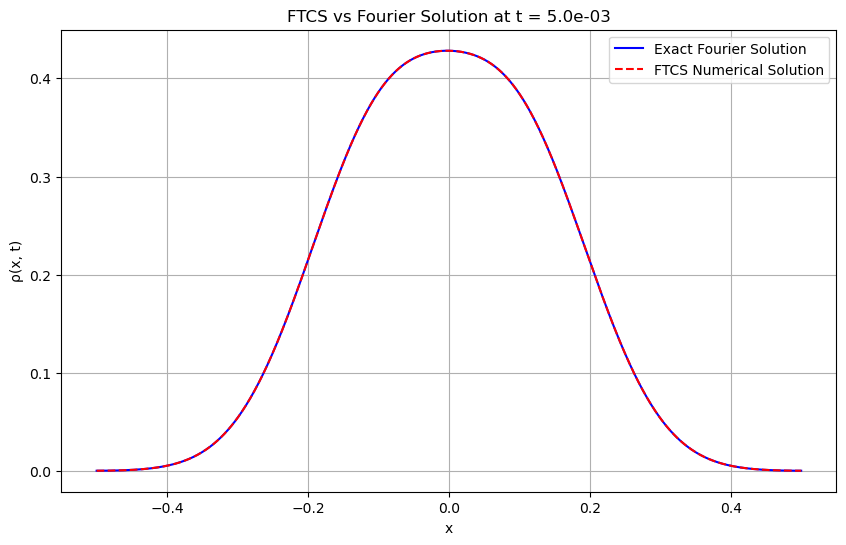

In [31]:
x, rho_fcts, rho_exact, T = compare_solutions()
plot_fcts_vs_fourier(x, rho_fcts, rho_exact, T)

We have an erro of $2.354\cdot 10-6$ which is very small. This means the FTCS matches the exact solution extremely well, verifying both accuracy and correctness. In the plot it can be seen that the FCTS matches the exact solution very well.

We only took the final time for the comparison, as if the numerical method is stable and accurate, then by final time, any accumulation of error should be evident. The total error is cumulative, so if FTCS deviates, it will show most clearly at large $T$.

#### d) BTCS scheme

Next we will implemnt the BCTS scheme. BTCS is  implicit, so at each time step we solve a linear system:

$\rho_i^{n+1} = \rho_i^n + \alpha \big[\rho_{i+1}^{n+1} - 2\rho_i^{n+1} + \rho_{i-1}^{n+1}]$ with $\alpha = \frac{\Delta t}{\Delta x^2}$

In [39]:
from scipy.sparse import diags
from scipy.sparse.linalg import factorized

In [56]:
def btcs_step(alpha, N):
    main_diag = (1 + 2 * alpha) * np.ones(N)
    off_diag = -alpha * np.ones(N - 1)

    A = diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], shape=(N,N), format='csc')
    A = A.toarray()
    A[0, -1] = -alpha
    A[-1, 0] = -alpha

    solver = factorized(A)
    return solver

In [44]:
def solve_diffusion_btcs(N=1000, T=5e-3):
    x, dx = initialize_grid(N)
    dt = 0.25 * dx**2
    alpha = dt / dx**2
    nt = int(T / dt)

    rho = initial_condition(x)
    save_times = [0, int(0.02 * nt), int(0.5 * nt), nt]
    snapshots = {0: rho.copy()}
    
    solver = btcs_step(alpha, N)

    for n in range(1, nt + 1):
        rho = solver(rho)
        if n in save_times:
            snapshots[n] = rho.copy()

    return x, snapshots, T, save_times, dt

c:\Users\Eaton\anaconda3\lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


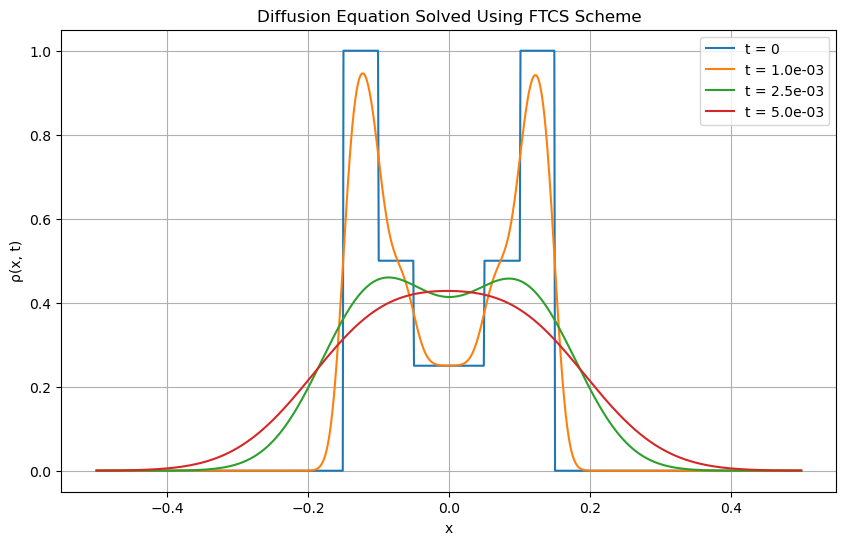

In [45]:
x, snapshots_btcs_lu, T, save_times_btcs_lu, dt_btcs = solve_diffusion_btcs()
plot_snapshots(x, snapshots_btcs_lu, save_times_btcs_lu, T, unstable=False)

In [90]:
def solve_diffusion_ftcs_final(N=1000, T=5e-3, dt=None):
    x, dx = initialize_grid(N)
    if dt is None:
        dt = 0.25 * dx**2
    alpha = dt / dx**2
    nt = int(T / dt)
    rho = initial_condition(x)
    for _ in range(nt):
        rho = ftcs_step(rho, alpha)
    return x, rho, dt

In [97]:
def solve_diffusion_btcs_final(N=1000, T=5e-3, dt=None):
    x, dx = initialize_grid(N)
    dt = 0.25 * dx**2
    alpha = dt / dx**2
    nt = int(T / dt)

    rho = initial_condition(x)
    save_times = [0, int(0.02 * nt), int(0.5 * nt), nt]
    snapshots = {0: rho.copy()}
    
    solver = btcs_step(alpha, N)

    for n in range(1, nt + 1):
        rho = solver(rho)
        if n in save_times:
            snapshots[n] = rho.copy()

    return x, rho, dt

In [98]:
def compare_btcs_ftcs(N=1000, T=5e-3, dt_factor=1.0):
    # Shared ∆t based on FTCS condition
    x, dx = initialize_grid(N)
    base_dt = 0.25 * dx**2
    dt = dt_factor * base_dt

    # Solve both
    _, rho_ftcs, _ = solve_diffusion_ftcs_final(N, T, dt)
    _, rho_btcs, _ = solve_diffusion_btcs_final(N, T, dt)

    # Compute relative L2 error
    error = np.linalg.norm(rho_ftcs - rho_btcs) / np.linalg.norm(rho_ftcs)
    print(f"BTCS vs FTCS L2 Relative Error (∆t = {dt:.2e}): {error:.2e}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(x, rho_ftcs, label="FTCS", linewidth=2)
    plt.plot(x, rho_btcs, '--', label="BTCS", linewidth=2)
    plt.title(f"BTCS vs FTCS Comparison at T = {T:.0e}, ∆t = {dt:.1e}")
    plt.xlabel("x")
    plt.ylabel("ρ(x, T)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return error

c:\Users\Eaton\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


BTCS vs FTCS L2 Relative Error (∆t = 2.50e-07): 1.40e-05


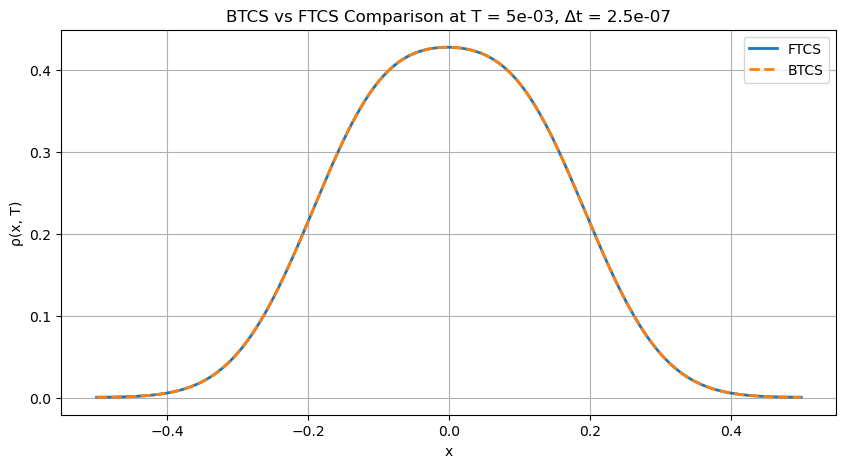

C:\Users\Eaton\AppData\Local\Temp\ipykernel_12104\4277446851.py:3: RuntimeWarning: overflow encountered in multiply
  rho_new[1:-1] = rho[1:-1] + alpha * (rho[2:] - 2 * rho[1:-1] + rho[:-2])
C:\Users\Eaton\AppData\Local\Temp\ipykernel_12104\4277446851.py:3: RuntimeWarning: overflow encountered in subtract
  rho_new[1:-1] = rho[1:-1] + alpha * (rho[2:] - 2 * rho[1:-1] + rho[:-2])
C:\Users\Eaton\AppData\Local\Temp\ipykernel_12104\4277446851.py:3: RuntimeWarning: overflow encountered in add
  rho_new[1:-1] = rho[1:-1] + alpha * (rho[2:] - 2 * rho[1:-1] + rho[:-2])
C:\Users\Eaton\AppData\Local\Temp\ipykernel_12104\4277446851.py:3: RuntimeWarning: invalid value encountered in add
  rho_new[1:-1] = rho[1:-1] + alpha * (rho[2:] - 2 * rho[1:-1] + rho[:-2])
C:\Users\Eaton\AppData\Local\Temp\ipykernel_12104\4277446851.py:3: RuntimeWarning: invalid value encountered in subtract
  rho_new[1:-1] = rho[1:-1] + alpha * (rho[2:] - 2 * rho[1:-1] + rho[:-2])
C:\Users\Eaton\AppData\Local\Temp\ipykernel_1

BTCS vs FTCS L2 Relative Error (∆t = 2.50e-06): nan


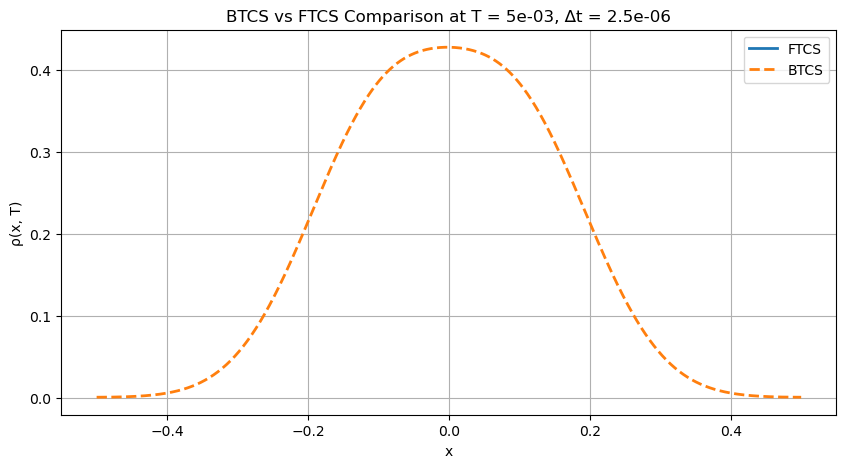

BTCS vs FTCS L2 Relative Error (∆t = 1.25e-05): nan


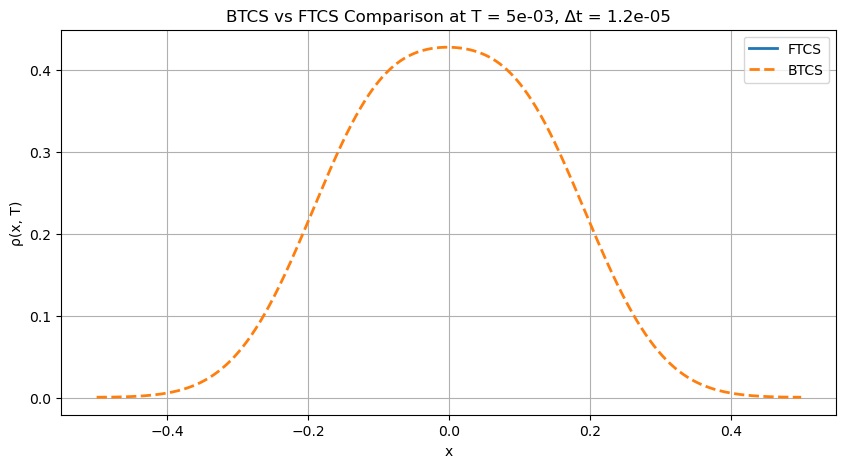

In [99]:
error_normal = compare_btcs_ftcs()
error_large = compare_btcs_ftcs(dt_factor=10)
error_very_large = compare_btcs_ftcs(dt_factor=50)

### Two-dimensional anisotropic diffusion with a source term

#### a)